# Creating a Neural Network

In this task, we will create a fully connected neural network using low-level mechanisms of TensorFlow.

The architecture of the neural network is depicted in the following diagram. As you can see, it has one input layer, two hidden layers, and an output layer. Sigmoid activation function will be used in the hidden layers, and softmax will be used in the output layer.

Some of the code for creating the network is already written; you need to fill in the gaps at the specified locations.

## Neural Network Architecture

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>

## About the MNIST Dataset

We will train this neural network on the MNIST dataset. This dataset consists of a large number of handwritten digit images, each of size $28 \times 28$ pixels. Each pixel in these images has a value ranging from 0 to 255.

As before, the dataset will be split into training and testing samples. However, we will perform normalization on all images, scaling pixel values to be in the range from 0 to 1 by dividing the brightness of each pixel by 255.

Additionally, the architecture of the neural network expects input in vector form. In our case, each data point in the dataset is represented as a matrix. So, what should we do? In this task, we will "flatten" the $28 \times 28$ matrix into a vector, resulting in a vector with 784 elements.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

You can find more information about the dataset [here](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install mplcyberpunk
import mplcyberpunk

plt.style.use("cyberpunk")

In [3]:
num_classes = 10  # Total number of classes, in our case, digits from 0 to 9
num_features = 784  # Number of features in the input vector, 28 * 28 = 784

learning_rate = 0.001  # Learning rate for the neural network
training_steps = 3000  # Maximum number of epochs
batch_size = 256  # We will update the network weights on a random subset of batch_size elements, not the entire dataset
display_step = 100  # Display the current loss value and accuracy every 100 iterations

n_hidden_1 = 128  # Number of neurons in the first hidden layer
n_hidden_2 = 256  # Number of neurons in the second hidden layer

In [4]:
from tensorflow.keras.datasets import mnist

# Load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert integer pixels to float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Flatten 28x28 pixel matrices into 784-element vectors
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Normalize pixel values
x_train, x_test = x_train / 255., x_test / 255.

# Shuffle training data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
# Create a neural network
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # First layer, consisting of 128 neurons
        self.layer_1 = DenseLayer(num_features, n_hidden_1)
        # Second layer, consisting of 256 neurons
        self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)
        # Output layer
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        # Remember that for the neural network output, we apply the softmax function to the output.
        # We do this so that
        # the output of the neural network takes values from 0 to 1 in accordance with the probability
        # of the input object belonging to one of the 10 classes
        x1 = self.layer_1(x, activation=0)
        x2 = self.layer_2(x1, activation=0)
        x3 = self.out_layer(x2, activation=1)

        return x3

In [6]:
# In this case, it's convenient to use cross-entropy as the error function
def cross_entropy(y_pred, y_true):
    # Encode label to a one-hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Calculate cross-entropy
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# We use accuracy as the quality metric
def accuracy(y_pred, y_true):
    corr_pred = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(corr_pred, tf.float32))

In [7]:
# Create an instance of a neural network
neural_net = NN(name="mnist")

# Neural network training function
def train(nn, input_x, output_y):
    # We will use stochastic gradient descent to adjust the network's weights
    optimizer = tf.optimizers.SGD(learning_rate)

    # Activation of automatic differentiation
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Create a list of parameters to optimize
        loss_2 = tf.reduce_sum([tf.nn.l2_loss(var) for var in neural_net.trainable_variables])
        loss += learning_rate * loss_2
        # Compute the gradient values based on them
    gradients = g.gradient(loss, neural_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

In [8]:
# Training the Network
loss_history = []  # Store the current loss of the neural network every display_step steps
accuracy_history = []  # Store the current accuracy of the neural network every display_step steps

# In this loop, we will train the neural network using a random subset from the training dataset
# using the `take` method available for the training dataset.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Update the weights of the neural network

    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acrcy = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acrcy)
        print(f"Step: {step}, loss: {loss:.4f}, accuracy: {acrcy:.4f}")

print("Training completed!")

Step: 100, loss: 328.7462, accuracy: 0.6602
Step: 200, loss: 250.9070, accuracy: 0.7266
Step: 300, loss: 190.5030, accuracy: 0.7461
Step: 400, loss: 189.2175, accuracy: 0.7891
Step: 500, loss: 139.2110, accuracy: 0.8281
Step: 600, loss: 194.1771, accuracy: 0.7891
Step: 700, loss: 109.3304, accuracy: 0.8438
Step: 800, loss: 131.1034, accuracy: 0.8555
Step: 900, loss: 120.3019, accuracy: 0.8828
Step: 1000, loss: 90.8851, accuracy: 0.8867
Step: 1100, loss: 118.7356, accuracy: 0.8789
Step: 1200, loss: 109.7329, accuracy: 0.8672
Step: 1300, loss: 101.5195, accuracy: 0.8789
Step: 1400, loss: 77.4023, accuracy: 0.9062
Step: 1500, loss: 85.9034, accuracy: 0.9141
Step: 1600, loss: 108.0515, accuracy: 0.8711
Step: 1700, loss: 59.0439, accuracy: 0.9180
Step: 1800, loss: 82.8772, accuracy: 0.9023
Step: 1900, loss: 73.9708, accuracy: 0.9180
Step: 2000, loss: 86.9754, accuracy: 0.9023
Step: 2100, loss: 62.1052, accuracy: 0.9375
Step: 2200, loss: 93.9785, accuracy: 0.8945
Step: 2300, loss: 75.6391, a

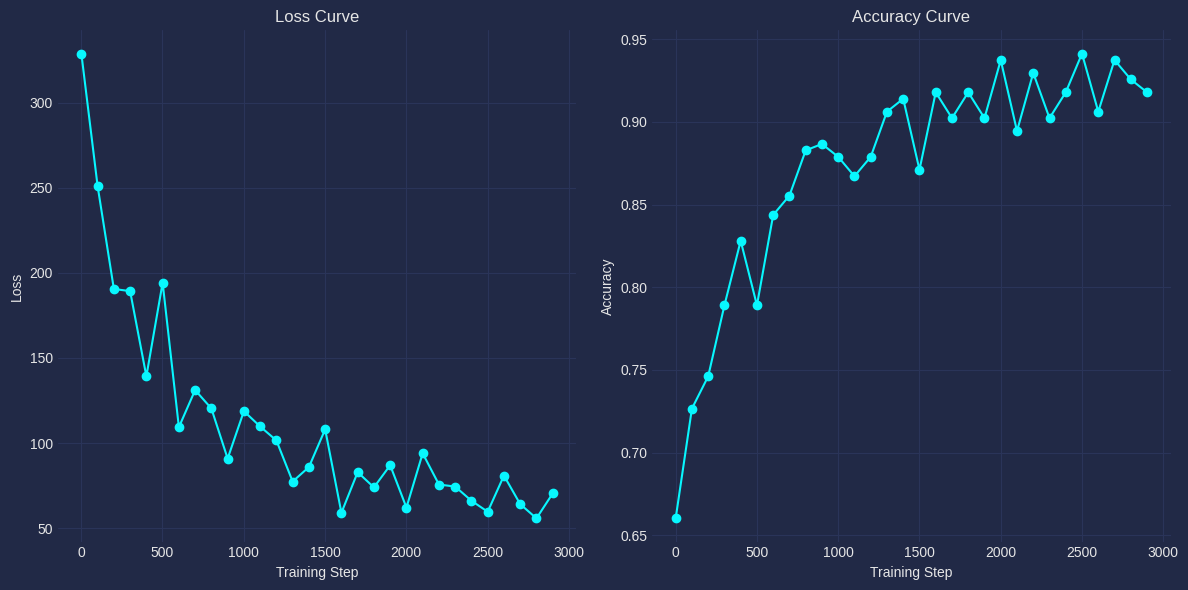

In [9]:
# Plot the graphs showing the change in accuracy and loss over steps
# If everything is done correctly, accuracy should increase while losses decrease
import matplotlib.pyplot as plt

# Plot the loss curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', linestyle='-')
plt.title('Loss Curve')
plt.xlabel('Training Step')
plt.ylabel('Loss')

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o', linestyle='-')
plt.title('Accuracy Curve')
plt.xlabel('Training Step')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [10]:
# Calculate the Accuracy of the Trained Neural Network
# Testing the model on test data
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Accuracy on test data: {test_acc.numpy()}")

Accuracy on test data: 0.9006999731063843


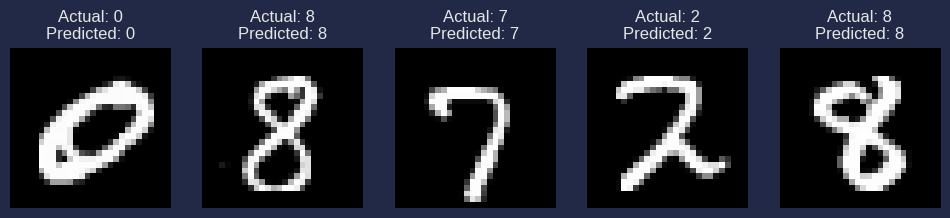

Accuracy on these 5 images: 100.00%


In [11]:
# Test the trained neural network on 10 images. Take 5 random images from the test dataset and feed them into the neural network.
# Display the images and write the neural network's predictions next to them.
# Draw a conclusion about whether your neural network makes mistakes, and if so, how often?
import random

# Select 5 random images from the test dataset
random_indices = random.sample(range(len(x_test)), 5)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Make predictions for the selected images
predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Display the images and write the neural network's predictions next to them
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Actual: {test_labels[i]}\nPredicted: {predicted_labels[i]}")
    plt.axis('off')

plt.show()

# Compare predictions with correct labels and calculate accuracy
correct_predictions = (predicted_labels == test_labels)
accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Accuracy on these 5 images: {accuracy * 100:.2f}%")


## __Conclusion:__

The neural network trained on the MNIST dataset achieved approximately 90.07% accuracy on the test data, demonstrating its ability to accurately classify handwritten digits. When tested on a small random sample of five images, the network correctly predicted all five digits, achieving a 100% accuracy rate. These results suggest that the network has learned to recognize and classify handwritten digits effectively.

--------------------------------------------------------------------------------